The following helper functions compute Minkowski sum, precursor set and $\mathcal{O}_{\infty}$ set. 

In [ ]:
import polytope as pt
import numpy as np
import matplotlib.pyplot as plt

# Minkowski sum between two polytopes based on vertex enumeration.
def minkowski_sum(X, Y):

    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))


def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    if not B.any():
        if not pt.is_empty(Wset):
            return pt.Polytope( pontryagin_diff(Xset, Wset).A @ A, Xset.b)
        else:
            return pt.Polytope(Xset.A @ A, Xset.b)
        
    if not pt.is_empty(Wset):
        tmp  = minkowski_sum( pontryagin_diff(Xset, Wset), pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    else:
        tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    
    
    
def Oinf(Xset, A, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap


***

# <font color=blue> 1. Formulation of CFTOC Problem with Pyomo</font>

First we construct a function which formulates and solves a finite time optimal control problem with quadratic cost, linear dynamics, and linear constraints. The function will be used in the next part of the homework as a part of your MPC controller. The problem is defined as below:
\begin{equation}
\begin{aligned}
\min_{x_1 \dots x_N,u_0 \dots u_{N-1}} & \quad x_N^{\top}Px_N+\sum_{k=0}^{N-1}x_k^{\top}Qx_k+u_k^{\top}Ru_k \\
\text{s.t.} & \quad x_{k+1} = Ax_k + Bu_k \quad \forall k=0\dots N-1\\
& \quad x_{min} \leq x_k \leq x_{max}  \quad \forall k=0\dots N-1 \\
& \quad u_{min} \leq u_k \leq u_{max}  \quad \forall k=0\dots N-1 \\
& \quad x_0 = x(0) \\
& \quad x_N \in \mathcal{X}_f
\end{aligned}
\end{equation}

Write a function in the following form which formulates the problem using pyomo and solves the problem using the solver $\texttt{ipopt}$. Test your code on several 1 and 2-state examples.

`def solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af):
    return [feas, xOpt, uOpt, JOpt]`


- $\texttt{feas}$ is a scalar logical indicating the feasibility of the CFTOC problem
- $\texttt{xOpt}$ is a $n_x \times (N+1)$ matrix of the optimal state trajectory, where $n_x$ is the state dimension
- $\texttt{uOpt}$ is a $n_u \times N$ matrix of the optimal input sequence, where $n_u$ is the input dimension
- $\texttt{JOpt}$ is a scalar of the optimal cost from the specified initial condition
- $\texttt{A, B}$ are the state and input matricies of the linear dynamics
- $\texttt{P}$ is the terminal cost matrix
- $\texttt{Q, R}$ are the stage cost matricies
- $\texttt{N}$ is the MPC horizon
- $\texttt{x0}$ is the initial condition
- $\texttt{xL, xU, uL, uU}$ are the box state and input constraints
- $\texttt{bf, Af}$ are used to represent the terminal set. If the terminal set ${\cal X}_f$ is a single point, ${\cal X}_f = \{ \bar{x}_N \}$, the input argument $\texttt{bf}$ is used to specify this single point $\bar{x}_N$, and the input argument $\texttt{Af = []}$ is used to designate this special case of a single-point terminal set. If the terminal set is described by a set of linear inequalities, it can be expressed using the inequality $A_f x_N \leq b_f$.


In [ ]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
import polytope as pt
import matplotlib.pyplot as plt

def solve_cftoc(A, B, P, Q, R, N, x0, x1U, x2U, uL, uU, bf, Af):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 1)
    model.nu = np.size(B, 1)
    model.nf = np.size(Af, 0)
    
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
    
    model.nfIDX = pyo.Set( initialize= range(model.nf), ordered=True )
    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    model.Af = Af
    model.bf = bf
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))
    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += model.x[i, t] * model.Q[i, j] * model.x[j, t] 
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
        for i in model.xIDX:
            for j in model.xIDX:               
                costTerminal += model.x[i, model.N] * model.P[i, j] * model.x[j, model.N]
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip
    

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    model.state_limit1 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0, t] <= x1U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit2 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x1U <= model.x[0, t]
                                    if t < N else pyo.Constraint.Skip)
    model.state_limit3 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1, t] <= x2U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit4 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x2U <= model.x[1, t]
                                    if t < N else pyo.Constraint.Skip)
    
    def final_const_rule(model, i):
        return sum(model.Af[i, j] * model.x[j, model.N] for j in model.xIDX) <= model.bf[i, 0] 
    
    model.final_const = pyo.Constraint(model.nfIDX, rule=final_const_rule)
    
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [feas, xOpt, uOpt, JOpt]



JOpt= 68.49999940299939
xOpt= [[-1.   0.5 -2.  -1. ]
 [ 3.  -3.5  3.5 -5. ]]


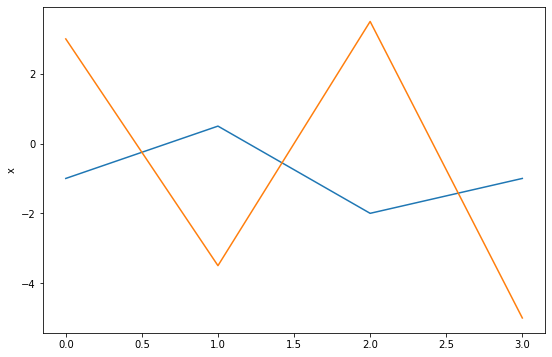

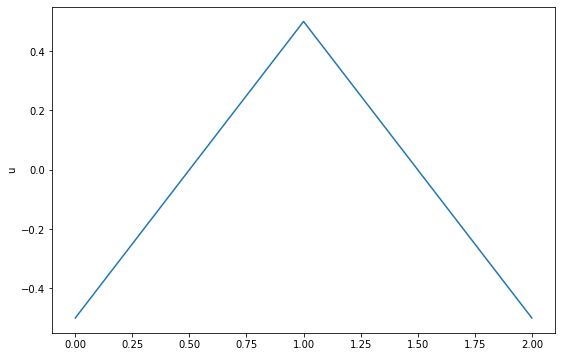

In [ ]:
# Test
A = np.array([[2, 1],
               [1, -1]])
B = np.array([[1],
              [-1]])
Q = np.eye(2)
R = 5*np.array([1]).reshape((1,1))
P = Q
N = 3
x1U = 5
x2U = 5
uL = -0.5
uU = 0.5
x0 = np.array([-1, 3])
Af = np.array([[1, 2],
               [0, 1]])
bf = np.array([[3],
               [-2]])

[feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, x1U, x2U, uL, uU, bf, Af)

print('JOpt=', JOpt)
print('xOpt=', xOpt)
fig = plt.figure(figsize=(9, 6))
plt.plot(xOpt.T)
plt.ylabel('x')
fig = plt.figure(figsize=(9, 6))
plt.plot(uOpt.T)
plt.ylabel('u')
plt.show()

***

# <font color=blue> 2. Persistently Feasible and Asymptotically Stable Linear MPC design </font>


Design several MPC controllers of the form: 

\begin{equation*}
   \begin{array}{lll}
       J_0^*(x_0)=  &\displaystyle{\min_{{U_0}}}& \displaystyle{ \color{red}{x_N'Px_N} + \sum_{k=0}^{{N}-1}
  x_k'Qx_k+u_k'Ru_k} \\
       &\text{subject to}   \\
       &&x_{k+1}=Ax_{k}+Bu_{k},\ k=0,\ldots,N-1\\
                       &&x_{k}\in\mathcal{X},~u_{k}\in\mathcal{U},~k=0,\ldots,N-1\\
                       && \color{red}{{x_{N}\in {\mathcal{X}_f} }} \\
                       && x_{0}=x(t)
    \end{array}
\end{equation*}
Here we will fix  the dynamics ($A$, $B$), the constraint sets $\mathcal{X}$ and $\mathcal{U}$, $Q=I_2$, $R=1$, and $N=3$ and only examine how the choice of $P$ and $\mathcal{X}_f$ affect the set of feasible initial states $\mathcal{X}_0$.



# <font color=blue> Part a) Approach 1 <font>

Choose $\mathcal{X}_f=\{0\}$ (note that $x_N'Px_N=0$ for any $P$ since $x_N=0$). Write code to formulate and solve the MPC problem over a simulation horizon $M$ from initial conditions $x_0$. 

$\texttt{feas}$ is a $1 \times M$ vector of logicals that indicate the feasibility of the problem at each simulation step (e.g. if the problem is feasible for 3 steps, then $\texttt{feas}=[\texttt{true true true false} ... \texttt{false}])$ . If the problem becomes infeasible at any time, it should  return empty arrays for $\texttt{xOpt}$, $\texttt{uOpt}$, and $\texttt{predErr}$.
$\texttt{xOpt}$ is an array of the optimal closed-loop trajectory of size $2 \times (M+1)$
$\texttt{uOpt}$ is an array of the optimal input sequence of size $1 \times M$
$\texttt{predErr}$ is a $2 \times (M-N+1)$ array of the $l_2$-norm of the difference between the open-loop predictions and the closed-loop trajectory for each state from simulation timestep 0 to $M-N$. To clarify further, the difference between the open-loop predictions and the closed-loop trajectory is a vector at each time, need to take the $l_2$-norm of this vector to compute an element of the $\texttt{predErr}$ array.

1.  Let $x(0) = [2,-1]^T$. Plot on the same figure the closed-loop state trajectory (plot $x(2)$ vs $x(1)$ as a solid line) as well as the open-loop trajectories (dashed lines) predicted by the MPC with a simulation horizon of $M=25$.

2. For the same $x(0) = [2,-1]^T$, analyze the mismatch between predicted vs closed-loop trajectories using the $\texttt{predErr}$ output as you increase $N$ in the MPC design. Print out how $\texttt{predErr}$ changes with $N$.

3. Plot the set of feasible initial states $\mathcal{X}_0$. 

(-0.10470111940139748,
 2.100223862828638,
 -1.1710969884152675,
 0.06139507510252618)

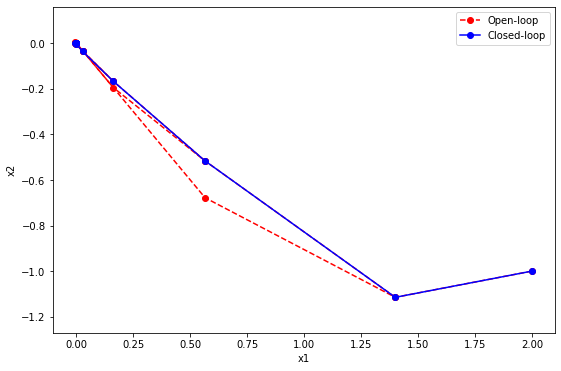

In [ ]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
import polytope as pt
import matplotlib.pyplot as plt

A = np.array([[1.2, 1],
               [0, 1]])
B = np.array([[0],
              [1]])
Q = np.eye(2)
R = 1*np.array([1]).reshape((1,1))
P = Q
N = 3
x1U = 15
x2U = 15
uL = -1
uU = 1
x0 = np.array([2, -1])
Af = np.array([[1, 0],
               [0, 1],
               [-1, 0],
               [0, -1]])
bf = np.array([[0],
               [0],
               [0],
               [0]])

nx = np.size(A, 1)
nu = np.size(B, 1)

M = 25
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M, ), dtype=bool)

fig = plt.figure(figsize=(9, 6))
for t in range(M):
    [feas[t], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, t], x1U, x2U, uL, uU, bf, Af)
    
    if not feas[t]:
        xOpt = []
        uOpt = []
        predErr = []
        print(feas)
        break
    
    line_op = plt.plot(x[0, :], x[1, :], 'ro--')
    xPred[:, :, t] = x
    
    
    xOpt[:, t+1] = x[:, 1]
    uOpt[:, t] = u[:, 0].reshape(nu, )

line_cp = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line_op[0], line_cp[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

In [ ]:
# Find the prediction error
for i in range(3,M+1):
  N = i
  xPred = np.zeros((nx, N+1, M))
  predErr = np.zeros((nx, M-N+1))
  for t in range(M):
      [feas[t], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, t], x1U, x2U, uL, uU, bf, Af)
      
      if not feas[t]:
          xOpt = []
          uOpt = []
          predErr = []
          print(feas)
          break
      
      xPred[:, :, t] = x
      
      
      xOpt[:, t+1] = x[:, 1]
      uOpt[:, t] = u[:, 0].reshape(nu, )

  for t in range(len(predErr[0])):
    err = xOpt[:, t:t+N+1] - xPred[:, :, t]
    predErr[:, t] = np.array([np.linalg.norm(err[0,:]), np.linalg.norm(err[1,:])]).reshape(nx, )

  # Print predErr
  print('N =', i)
  print(predErr)

N = 3
[[0.16158 0.0278  0.00242 0.00448 0.00225 0.00077 0.00018 0.00002 0.00001
  0.00001 0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.     ]
 [0.23172 0.04532 0.00289 0.00546 0.00297 0.00107 0.00027 0.00003 0.00001
  0.00001 0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.     ]]
N = 4
[[0.10306 0.02437 0.00114 0.00331 0.00258 0.00135 0.00056 0.00019 0.00005
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]
 [0.10726 0.02873 0.00396 0.00246 0.00222 0.00124 0.00055 0.0002  0.00006
  0.00001 0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]]
N = 5
[[0.0365  0.00415 0.00347 0.0034  0.00202 0.00095 0.00037 0.00012 0.00002
  0.      0.00001 0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.03514 0.00669 0.00184 0.0023  0.00149 0.00075 0.00031 0.00011 0.00003
  0.    

In [ ]:
xU = 15
uU = 1

# constraint sets represented as polyhedra
X = pt.Polytope(np.array([[1.0, 0], 
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]), 
                np.array([[xU], 
                          [xU],
                          [xU],
                          [xU]]))

U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([uU, uU]).reshape(2,1))


# target set

# Since the Polytope package cannot handle non full-dimensional
# polytopes, we need to define an epsilon box around zero in
# order to run the code:
eps = 0.001
S = pt.box2poly([[-eps, eps], [-eps, eps]])  # the target set S is Xf = {0}



In [ ]:
import scipy.linalg

# Computation of X0

Finf = scipy.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
Acl = A - B @ Finf
O_inf_1 = Oinf(S, Acl)
             
N = 3

C = {}
PreS = precursor(O_inf_1, A, U, B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0_1 = C[N-1]

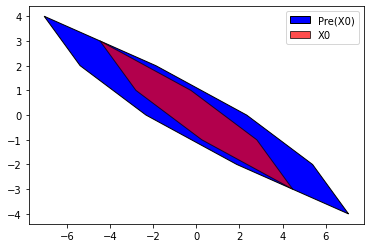

In [ ]:
# Plot X0
PreX0_1 = precursor(X0_1, A, U, B)
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


# X.plot(ax, color='b', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
PreX0_1.plot(ax, color='b', alpha=1, linestyle='solid', linewidth=1)
X0_1.plot(ax, color='r', alpha=0.7, linestyle='solid', linewidth=1)       # initial feasible set 
ax.legend(['Pre(X0)', 'X0'])

ax.autoscale_view()
# ax.axis('equal')
plt.show()



***

# <font color=blue> Part b) Approach 2 </font>

To design our MPC, now use a stabilizing controller $u = Kx$ where $K$ is:
\begin{align*}
K &= -\begin{bmatrix}  1.595  &  2.35 \end{bmatrix}
\end{align*}
which  produces a stable closed loop system with poles at 0.1 and -0.25. Let $\color{red}{{X}_f}$ be the maximal invariant set $O_\infty$ for a closed loop system $x(k+1) = (A+BK)x(k)$ subject to
constraints (3).
Find a new terminal cost such that it is a Lyapunov Function for $x \in \color{red}{{X}_f} = O_\infty$. Print out $\texttt{feas}$, $\texttt{xOpt}$, $\texttt{uOpt}$, and $\texttt{predErr}$ arrays.

$\texttt{feas}$ is a $1 \times M$ vector of logicals that indicate the feasibility of the problem at each simulation step (e.g. if the problem is feasible for 3 steps, then $\texttt{feas}=[\texttt{true true true false} ... \texttt{false}]$ . If the problem becomes infeasible at any time, it should return empty arrays for $\texttt{xOpt}$, $\texttt{uOpt}$, and $\texttt{predErr}$.
$\texttt{xOpt}$ is an array of the optimal closed-loop trajectory of size $2 \times (M+1)$
$\texttt{uOpt}$ is an array of the optimal input sequence of size $1 \times M$
$\texttt{predErr}$ is a $2 \times (M-N+1)$ array of the $l_2$-norm of the difference between the open-loop predictions and the closed-loop trajectory for each state from simulation timestep 0 to $M-N$. To clarify further, the difference between the open-loop predictions and the closed-loop trajectory is a vector at each time, you need to take the $l_2$-norm of this vector to compute an element of the $\texttt{predErr}$ array.

Call the function $\texttt{solve_cftoc}$, which was wrote in Problem 1, in the simulation time loop.

1.  Let $x(0) = [2,-1]^T$. Plot on the same figure the closed-loop state trajectory (plot $x(2)$ vs $x(1)$ as a solid line) as well as the open-loop trajectories (dashed lines) predicted by the MPC with a simulation horizon of $M=25$.

2. For the same $x(0) = [2,-1]^T$, analyze the mismatch between predicted vs closed-loop trajectories using the $\texttt{predErr}$ output as you increase $N$ in the MPC design. Show with plots how this prediction error changes with $N$.

3. Plot the set of feasible initial states $\mathcal{X}_0$. Note: You have two options by using brute-force gridding or by using polyhedral projections.

In [ ]:
import scipy.linalg
import numpy as np
import polytope as pt

A = np.array([[1.2, 1],
               [0, 1]])
B = np.array([[0],
              [1]])
Q = np.eye(2)
R = 1*np.array([1]).reshape((1,1))
N = 3
x1U = 15
x2U = 15
uL = -1
uU = 1
x0 = np.array([2, -1])

K = -np.array([[1.595, 2.35]])
A_cl = A + B @ K   # closed-loop A matrix
P_2 = scipy.linalg.solve_discrete_lyapunov(A_cl, Q)    # The weight for terminal cost
S = X.intersect(pt.Polytope(U.A @ K, U.b))           
O_inf_2 = Oinf(S, A_cl)
Af = O_inf_2.A
bf = O_inf_2.b.reshape(np.size(Af,0), 1)

(-0.1300572309725992,
 2.101431296712981,
 -1.0722951122921425,
 0.08490572110317628)

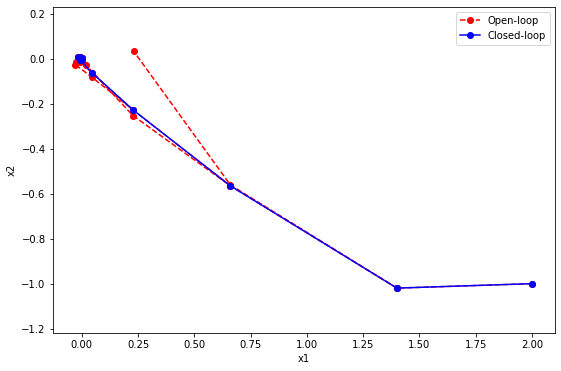

In [ ]:
nx = np.size(A, 1)
nu = np.size(B, 1)

P = P_2

M = 25

xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M, ), dtype=bool)

fig = plt.figure(figsize=(9, 6))
for t in range(M):
    [feas[t], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, t], x1U, x2U, uL, uU, bf, Af)
    
    if not feas[t]:
        xOpt = []
        uOpt = []
        predErr = []
        print(feas)
        break
    
    line_op = plt.plot(x[0, :], x[1, :], 'ro--')
    xPred[:, :, t] = x
    
    
    xOpt[:, t+1] = x[:, 1]
    uOpt[:, t] = u[:, 0].reshape(nu, )

line_cp = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line_op[0], line_cp[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

In [ ]:
# Find the prediction error
for i in range(3,M+1):
  N = i
  xPred = np.zeros((nx, N+1, M))
  predErr = np.zeros((nx, M-N+1))
  for t in range(M):
      [feas[t], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, t], x1U, x2U, uL, uU, bf, Af)
      
      if not feas[t]:
          xOpt = []
          uOpt = []
          predErr = []
          print(feas)
          break
      
      xPred[:, :, t] = x
      
      
      xOpt[:, t+1] = x[:, 1]
      uOpt[:, t] = u[:, 0].reshape(nu, )

  for t in range(len(predErr[0])):
    err = xOpt[:, t:t+N+1] - xPred[:, :, t]
    predErr[:, t] = np.array([np.linalg.norm(err[0,:]), np.linalg.norm(err[1,:])]).reshape(nx, )

  # Print predErr
  print('N =', i)
  print(predErr)

N = 3
[[0.00389 0.02549 0.01949 0.00963 0.00348 0.00078 0.00007 0.0002  0.00013
  0.00006 0.00002 0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.     ]
 [0.25984 0.04218 0.03045 0.02535 0.01339 0.00524 0.00142 0.00021 0.00024
  0.00017 0.00009 0.00003 0.00001 0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.     ]]
N = 4
[[0.06074 0.03308 0.01441 0.00511 0.00135 0.00018 0.00017 0.00014 0.00008
  0.00003 0.00001 0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]
 [0.07941 0.02037 0.01346 0.0088  0.00451 0.00191 0.00067 0.00019 0.00005
  0.00003 0.00002 0.00001 0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]]
N = 5
[[0.04221 0.01738 0.00591 0.0015  0.00029 0.00027 0.00019 0.0001  0.00005
  0.00002 0.00001 0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.02089 0.0108  0.0079  0.00448 0.0021  0.00083 0.00027 0.00007 0.00002
  0.0000

***

In [ ]:
import scipy.linalg

N = 3

C = {}
PreS = precursor(O_inf_2, A, U, B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0_2 = C[N-1]

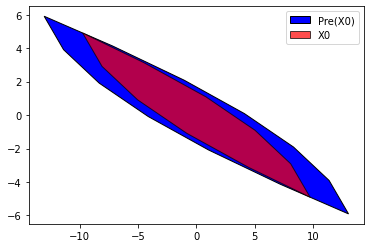

In [ ]:
# Plot X0
PreX0_2 = precursor(X0_2, A , U, B)
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# X.plot(ax, color='b', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
PreX0_2.plot(ax, color='b', alpha=1, linestyle='solid', linewidth=1)
X0_2.plot(ax, color='r', alpha=0.7, linestyle='solid', linewidth=1)       # initial feasible set 
ax.legend(['Pre(X0)',  'X0'])

ax.autoscale_view()
plt.show()

# <font color=blue> Part c) Approach 3 </font>
Now set $\mathcal{X}_f$ to be the maximal invariant set $O_\infty$ for the closed loop system $x(k+1) = (A+BF_\infty)x(k)$ subject to
the given constraints. Here $F_\infty$ is the infinite time LQR controller for the system $x(k+1) = Ax(k)+Bu(k)$ with weights $Q$ and $R$ defined previously, such that $u(k)=F_{\infty}x(k)$. Choose the terminal cost $P$ to be the infinite time cost associated with the controller $F_\infty$. 

1. Plot $O_\infty$ in this approach  with the one in Approach 2 and discuss the differences.

2. Let $x(0) = [2,-1]^T$ and plot the closed-loop state trajectory as well as the open-loop trajectories predicted by the MPC with this new terminal cost and terminal constraint for 25 simulation steps ($N$ is still equal to 3). How does this compare to the other solutions?

3. Plot the set of  feasible initial states $\mathcal{X}_0$. Note: You have two options by using brute-force gridding or by using polyhedral projections.

In [ ]:
import scipy.linalg

A = np.array([[1.2, 1],
               [0, 1]])
B = np.array([[0],
              [1]])
Q = np.eye(2)
R = 1*np.array([1]).reshape((1,1))
P = Q
N = 3
x1U = 15
x2U = 15
uL = -1
uU = 1
x0 = np.array([2, -1])

def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation  
    P_inf = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    F_inf = - scipy.linalg.inv(B.T @ P_inf @ B + R) @ (B.T @ P_inf @ A)

    # stability check 
    eigVals, eigVecs = scipy.linalg.eig(A + B @ F_inf)

    return F_inf, P_inf, eigVals

F_inf, P_inf, eigvals = dlqr(A, B, Q, R)
A_cl = A + B @ F_inf
S = X.intersect(pt.Polytope(U.A @ F_inf, U.b))
O_inf_3 = Oinf(S, A_cl)
Af = O_inf_3.A
bf = O_inf_3.b.reshape(np.size(Af,0), 1)


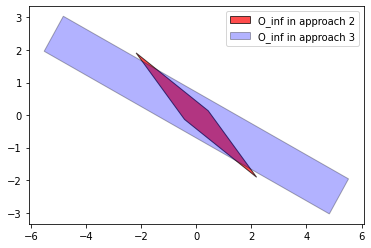

In [ ]:
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

O_inf_2.plot(ax, color='r', alpha=0.7, linestyle='solid', linewidth=1)  
O_inf_3.plot(ax, color='b', alpha=0.3, linestyle='solid', linewidth=1)    
ax.legend(['O_inf in approach 2', 'O_inf in approach 3', 'X0', 'Oinf'])

ax.autoscale_view()
plt.show()

(-0.10360611286862836,
 2.100171719660411,
 -1.0500974944048156,
 0.0520473825011271)

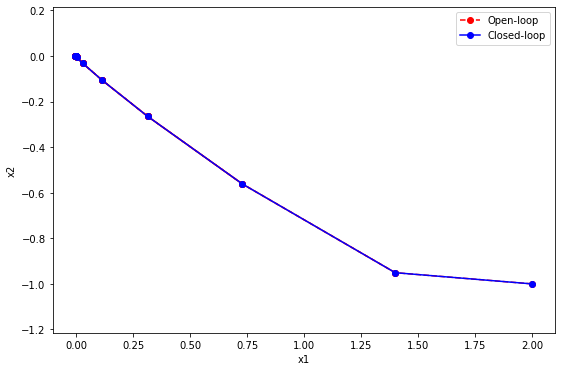

In [ ]:
nx = np.size(A, 1)
nu = np.size(B, 1)

P = P_inf

M = 25

xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M, ), dtype=bool)

fig = plt.figure(figsize=(9, 6))
for t in range(M):
    [feas[t], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, t], x1U, x2U, uL, uU, bf, Af)
    
    if not feas[t]:
        xOpt = []
        uOpt = []
        predErr = []
        print(feas)
        break
    
    line_op = plt.plot(x[0, :], x[1, :], 'ro--')
    xPred[:, :, t] = x
    
    
    xOpt[:, t+1] = x[:, 1]
    uOpt[:, t] = u[:, 0].reshape(nu, )

line_cp = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line_op[0], line_cp[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

In [ ]:
N = 3

C = {}
PreS = precursor(O_inf_3, A, U, B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0_3 = C[N-1]

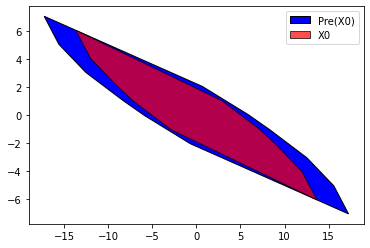

In [ ]:
# Plot X0
PreX0_3 = precursor(X0_3, A, U, B)
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#X.plot(ax, color='b', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
PreX0_3.plot(ax, color='b', alpha=1, linestyle='solid', linewidth=1)
X0_3.plot(ax, color='r', alpha=0.7, linestyle='solid', linewidth=1)       # initial feasible set 
ax.legend(['Pre(X0)',  'X0'])

ax.autoscale_view()
plt.show()

***

# <font color=blue> Part d) Comparison </font>
Plot and compare $\mathcal{X}_0$ for the three MPC designs (Approach 1,2, and 3) for $N=3$.

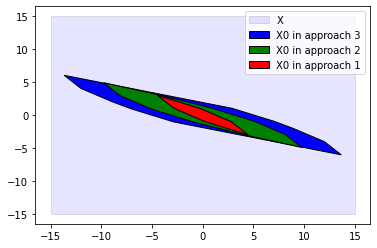

In [ ]:
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

X.plot(ax, color='b', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      
X0_3.plot(ax, color='b', alpha=1, linestyle='solid', linewidth=1) 
X0_2.plot(ax, color='g', alpha=1, linestyle='solid', linewidth=1) 
X0_1.plot(ax, color='r', alpha=1, linestyle='solid', linewidth=1)       

ax.legend(['X',  'X0 in approach 3',  'X0 in approach 2',  'X0 in approach 1'])

ax.autoscale_view()
plt.show()